In [2]:
import nibabel as nib
import mne

In [4]:
SUBJECT_DIR = "/home/carlos/Datasets/subjects/MNIAverage"
CEREBRA_DIR = "/home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62"

In [6]:
!mri_info --vox2ras f"{CEREBRA_DIR}/CerebrA.nii"

error: niiRead(): error opening file f/home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.nii 


In [3]:
!mri_info --vox2ras f"{CEREBRA_DIR}/cerebra.mgz"

error: mghRead(f/home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/cerebra.mgz, -1): could not open file 


(193, 229, 193)

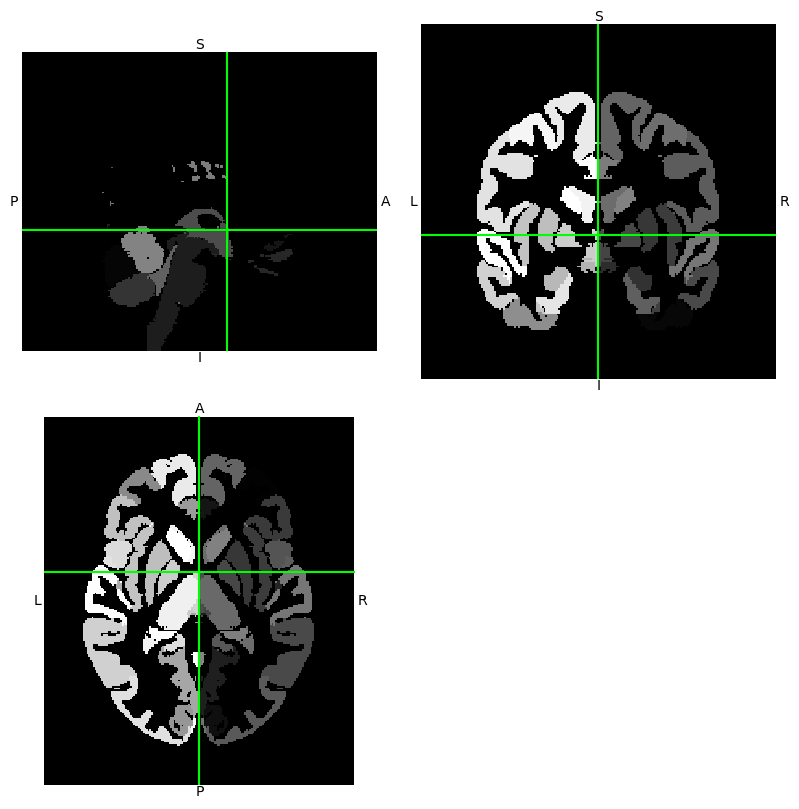

In [10]:
cerebra_img = nib.load(f"{CEREBRA_DIR}/CerebrA.nii")
cerebra_img_data = cerebra_img.get_fdata()
cerebra_img.orthoview()
cerebra_img_data.shape

(256, 256, 256)

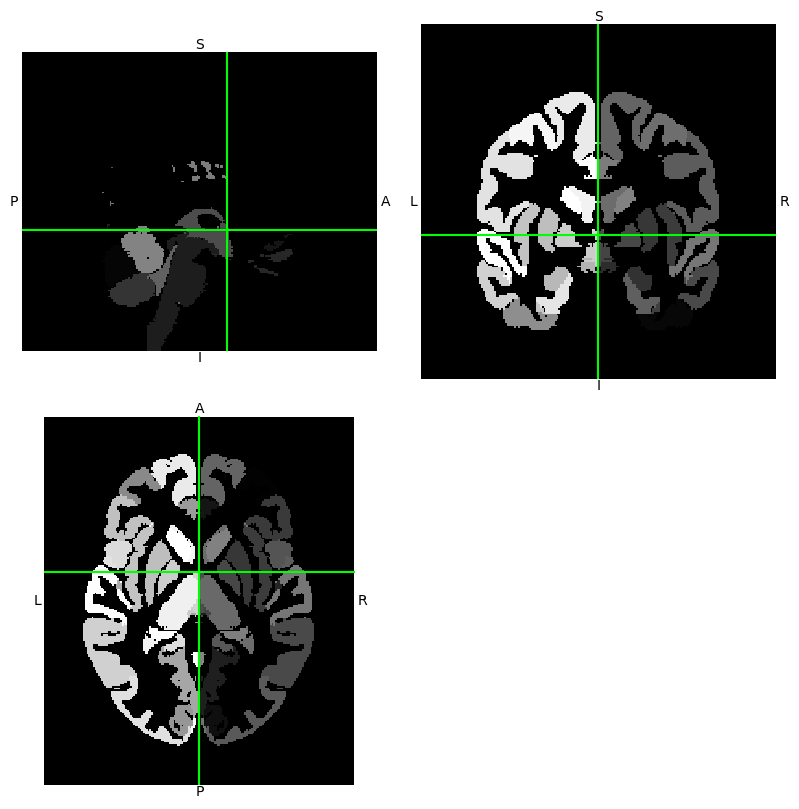

In [14]:
t1_img = nib.load(f"{SUBJECT_DIR}/mri/T1.mgz")
t1_data = t1_img.get_fdata()
cerebra_img.orthoview()
t1_img.shape

### Transform .nii to .mgz

In [20]:
!mri_convert $CEREBRA_DIR"/CerebrA.nii" $CEREBRA_DIR"/CerebrA.mgz"

mri_convert /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.nii /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz 
reading from /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.nii...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz...


### Switch to head coordinate frame and store in CerebrA_in_head.mgz

In [21]:
!mri_vol2vol --mov $CEREBRA_DIR"/CerebrA.mgz" --o $CEREBRA_DIR"/CerebrA_in_head.mgz" --regheader --targ $SUBJECT_DIR/mri/T1.mgz 

movvol /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz
targvol /home/carlos/Datasets/subjects/MNIAverage/mri/T1.mgz
outvol /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA_in_head.mgz
invert 0
tal    0
talres 2
regheader 1
noresample 0
interp  trilinear (1)
precision  float (3)
Gdiag_no  -1
Synth      0
SynthSeed  1687427526

Computing registration based on scanner-to-scanner

Final tkRAS-to-tkRAS Matrix is:
-1.00000   0.00000   0.00000   0.00000;
 0.00000   0.00000   1.00000   0.00000;
 0.00000  -1.00000   0.00000   0.00000;
 0.00000   0.00000   0.00000   1.00000;


Vox2Vox Matrix is:
-1.00000   0.00000   0.00000   224.50000;
 0.00000   0.00000   1.00000  -13.50000;
 0.00000  -1.00000   0.00000   224.50000;
 0.00000   0.00000   0.00000   1.00000;

Resampling
Output registration matrix is identity

mri_vol2vol done


(256, 256, 256)

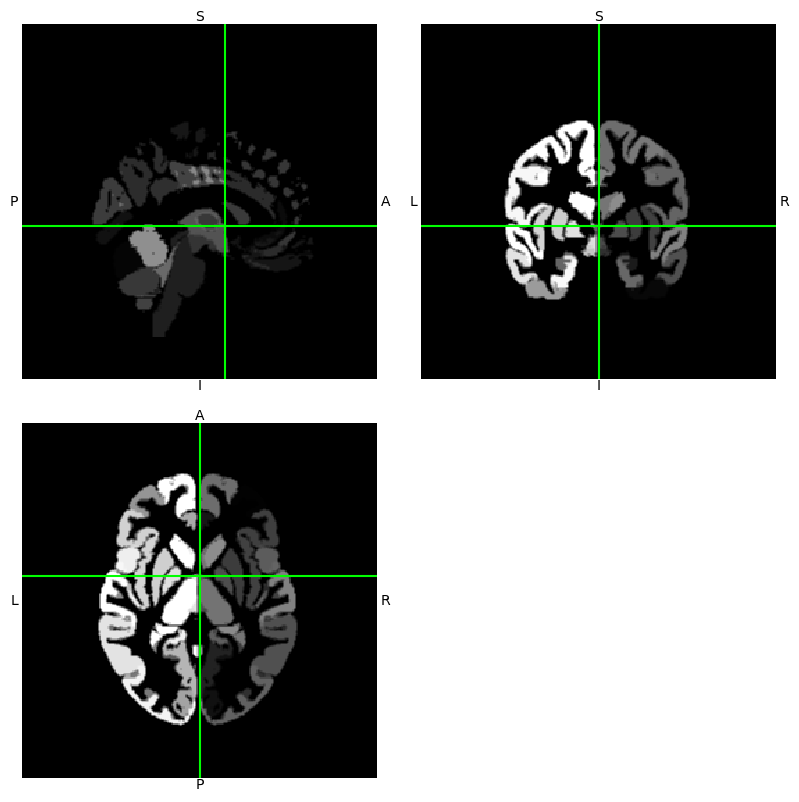

In [22]:
cerebra_img = nib.load(f"{CEREBRA_DIR}/CerebrA_in_head.mgz")
cerebra_img_data = cerebra_img.get_fdata()
cerebra_img.orthoview()
cerebra_img_data.shape